In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sargas import *
import tqdm
import matplotlib.pyplot as plt

sns.set_palette("Dark2")
sns.set_style("ticks")
sns.set_context("talk")

# Assignment 2: Chemical Potential and Vapor-Liquid Equilibria (VLE)

## Introduction <a id="Introduction"/>

The vapor-liquid coexistence point of a Lennard-Jones system at a
certain temperature can be found by different simulation techniques. In
this exercise we will locate the phase coexistence calculating the equation of
state of the system using simulations in the canonical ensemble (NVT),
and we will impose the conditions of phase equilibrium.

We will use NVT simulations to create the trajectories from which the chemical potential will be computed.
All simulations of this assignment will be conducted using a **truncated Lennard-Jones potential without tail corrections**.

## Table of Contents <a id="toc"/>

- [Introduction](#Introduction)
- [The Chemical Potential from the Partition Function](#Chemical-Potential)
- [Widom's Particle Insertion](#Widom)
- [Compiling and Testing](#compiling-And-Testing)
- [Your Tasks](#tasks)
  - [1. Nearest Image Convention and Periodic Boundary Conditions](#PBC)
  - [2. Run a Simulation](#Simulation)
  - [3. Pressure and Ideal Gas Law](#Pressure)
  - [4. The Truncated and Shifted Lennard-Jones Potential](#Truncated-Shifted)
  - [5. Tail Corrections](#Tail-Corrections)
  - [6. Comparison to NIST](#NIST)

## The Chemical Potential from  the Partition Function <a id="Chemical-Potential"/>

[↑ back to top](#toc)

We can divide the chemical potential into two additive contributions, one for the ideal gas and one residual contribution:

\begin{align}
\mu = \mu^\text{ig} + \mu^\text{res}
\end{align}

Recall that the chemical potential is the partial derivative of the Helmholtz energy with respect to the amount of substance (or here: the number of particles). For a pure substance, we can write:

\begin{align}
\mu &= \left(\frac{\partial A}{\partial N}\right)_{T, V} \\
&= -k_BT \left(\frac{\partial \ln Q_\text{NVT}}{\partial N}\right)_{T, V} \\
\end{align}

with the quantum corrected partition function of the canonical ensemble for mono-atomic substances (omitting the internal partition function), $Q_\text{NVT}$:

\begin{align}
Q_\text{NVT} = \frac{1}{N!\Lambda^{3N}}\int e^{-\beta U(\mathbf{r}^N)} \mathrm{d}\mathbf{r}^N
\end{align}

For an ideal gas, we set the potential energy of the system to zero and then take the derivative:

\begin{align}
Q_\text{NVT}^\text{ig} &= \frac{1}{N!\Lambda^{3N}}\underbrace{\int \mathrm{d}\mathbf{r}^N}_{=V^N} \\
\mu^\text{ig} &= -k_BT \frac{\partial}{\partial N} \left( N\ln V - \ln N! - N\ln\Lambda^3 \right) \\
&= k_BT \ln \left[\rho\Lambda^3\right]
\end{align}



## Widom's Particle Insertion <a id="Widom"/>

[↑ back to top](#toc)

The residual contribution to the chemical potential requires integration over all possible microstates of the system for the given control variables $N, V$ and $T$. However, for a molecular system, the smallest possible change in the amount of substance ($N$) is removing or adding a single molecule or particle. We can approximate the chemical potential by adding a (ghost) particle to the system:

\begin{align}
\mu &= \frac{A(N+\Delta N, V, T) - A(N, V, T)}{\Delta N} \\
&\underbrace{=}_{\Delta N = 1} A(N+1, V, T) - A(N, V, T) \\
&= -k_B T \ln \frac{Q_\text{N+1VT}}{Q_\text{NVT}} \\
&= \mu^\text{ig} - k_BT \ln \langle e^{-\beta \Delta^+ U(\mathbf{r}^N, \mathbf{r}^+)}  \rangle
\end{align}

with $\Delta^+ U(\mathbf{r}^N, \mathbf{r}^+)$ being the energy of the ghost particle (at position $\mathbf{r}^+$) with all other particles (at positions $\mathbf{r}^N$) in the system.

The tail correction is approximately twice the per-particle energy tail correction. 

\begin{equation}
  \beta\mu^\text{tail} \approx 2 u^\text{tail}(\rho)
\end{equation}

For very small numbers of particles, this approximation is not suitable.

## Compiling and Testing <a id="compiling-And-Testing"/>

[↑ back to top](#toc)

To **compile** the code (*which does not build the python module*), use 

```
RUSTFLAGS="-C target-cpu=native" cargo build --release
```

To **test** the code, type

```
RUSTFLAGS="-C target-cpu=native" cargo test --release --test assignment2
```
<div class="alert alert-danger">A red box signals that there is a <strong>test</strong> for an implementation! Run the test with <code>RUSTFLAGS="-C target-cpu=native" cargo test --release --test assignment2</code></div>

To build the **Python module**, type

```
RUSTFLAGS="-C target-cpu=native" maturin develop --release
```

If the last step fails stating that "the resource is currently in use" (or something similar) make sure to **stop the Jupyter kernel** and try running the command again.

---
## Your Tasks <a id="tasks"/>

[↑ back to top](#toc)

---
1. Widom Algorithm

Implement the test particle insertion algorithm in `src/system.rs` in the function `ghost_particle_energy_sum`.

In [4]:
def nvt(nparticles, temperature, density, nequilibration, nproduction, nsample, ntrajectory):
    """Run a NVT simulation with rc=3.0 and tail corrections.
    
    Parameters
    ----------
    nparticles : int
        number of particles
    temperature : float
        reduced temperature
    density : float
        reduced density
    nequilibration : int
        number of equilibration steps
    nproduction : int
        number of production steps
    nsample : int
        sample after this many steps
        
    Returns
    -------
    pd.DataFrame : data frame containing results
    """   
    rc = 3.0
    tail_correction = True

    # Build the system
    lennard_jones = Potential.lennard_jones(1.0, 1.0, rc, tail_correction)
    configuration = Configuration.lattice(nparticles, density)
    system = System(configuration=configuration, potential=lennard_jones)

    # Build the propagator
    particle_displacement = MCMove.displace_particle(0.1, 0.4, temperature)
    propagator = MonteCarlo([particle_displacement], [1], temperature)

    # Build the simulation
    simulation = Simulation.monte_carlo(system, propagator)

    # Run equilibration
    for _ in tqdm.tqdm(range(nequilibration), desc="Equilibration"):
        simulation.run(nparticles)
    
    # stop adjusting the maximum displacement
    simulation.deactivate_propagator_updates()
    
    # Add sampler
    properties = Sampler.properties(nparticles * nsample)
    trajectory = Sampler.trajectory(f"{temperature}_t_{density}_rho.gro", nparticles * ntrajectory)
    simulation.add_sampler(properties)
    simulation.add_sampler(trajectory)
    
    # Run production
    for _ in tqdm.tqdm(range(nproduction), desc="Production   "):
        simulation.run(nparticles)
    
    return pd.DataFrame(properties.data)

In [36]:
temperature = 0.8
densities = [0.9, 1.0, 1.1]#[0.02, 0.03, 0.04, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

In [37]:
for density in densities:
    _ = nvt(500, temperature, density, 5000, 20000, 100, 20)

Production   : 100%|██████████| 20000/20000 [01:58<00:00, 168.95it/s]


In [61]:
def rerun_trajectory(filename, temperature):
    """Read a trajectory and apply samplers.
    
    Parameters
    ----------
    temperature : float
        reduced temperature
        
    Returns
    -------
    (pd.DataFrame, pd.DataFrame):
        properties, chemical_potential
    """   
    rc = 3.0
    tail_correction = True

    lennard_jones = Potential.lennard_jones(1.0, 1.0, rc, tail_correction)
    
    # Build the simulation
    simulation = Simulation.rerun_trajectory(lennard_jones, filename)

    # Add sampler
    properties = Sampler.properties(1)
    widom = Sampler.widom(1, temperature, ninsertions=1500)
    simulation.add_sampler(properties)
    simulation.add_sampler(widom)
    
    try:
        simulation.run(100000)
    except Exception as e:
        print(e)
    
    return pd.DataFrame(properties.data), pd.DataFrame(widom.data)

In [62]:
import glob
import re

PATTERN = re.compile("(\d+.\d+)_t_(\d+.\d+)_rho.gro")

In [63]:
results = {}

for filename in glob.glob("*rho.gro"):
    print(filename)
    t, rho = PATTERN.search(filename).groups()
    t = float(t)
    rho = float(rho)
    ps, mus = rerun_trajectory(filename, t)
    results.update({(t, rho): (ps, mus)})

1.0_t_0.5_rho.gro
can not read file '1.0_t_0.5_rho.gro' at step 1000: maximal step is 999
0.8_t_0.02_rho.gro
can not read file '0.8_t_0.02_rho.gro' at step 1000: maximal step is 999
0.8_t_0.03_rho.gro
can not read file '0.8_t_0.03_rho.gro' at step 1000: maximal step is 999
0.8_t_0.04_rho.gro
can not read file '0.8_t_0.04_rho.gro' at step 1000: maximal step is 999
0.8_t_0.05_rho.gro
can not read file '0.8_t_0.05_rho.gro' at step 1000: maximal step is 999
0.8_t_0.075_rho.gro
can not read file '0.8_t_0.075_rho.gro' at step 1000: maximal step is 999
0.8_t_0.1_rho.gro
can not read file '0.8_t_0.1_rho.gro' at step 1000: maximal step is 999
0.8_t_0.2_rho.gro
can not read file '0.8_t_0.2_rho.gro' at step 1000: maximal step is 999
0.8_t_0.3_rho.gro
can not read file '0.8_t_0.3_rho.gro' at step 1000: maximal step is 999
0.8_t_0.4_rho.gro
can not read file '0.8_t_0.4_rho.gro' at step 1000: maximal step is 999
0.8_t_0.5_rho.gro
can not read file '0.8_t_0.5_rho.gro' at step 1000: maximal step is 99

In [64]:
def means(temperature, density, props, mus):
    return {
        "temperature": temperature,
        "density": density,
        "pressure": density * temperature + props.pressure.mean(),
        "energy": props.potential_energy.mean(),
        "mu": mus.chemical_potential.values[-1]
    }

In [65]:
summary = []
for (temperature, density), (props, mus) in results.items():
    summary.append(means(temperature, density, props, mus)) 

In [70]:
df = pd.DataFrame(summary)
df = df.drop(index=0)
df = df.drop(index=16)
df = df.drop(index=15)
df

,temperature,density,pressure,energy,mu
1,0.8,0.020,0.013458,-115.059656,-4.225451
2,0.8,0.030,0.018402,-173.884425,-3.979239
3,0.8,0.040,0.021795,-244.862760,-3.856443
4,0.8,0.050,0.023618,-333.214893,-3.814260
5,0.8,0.075,0.022314,-588.821797,-3.919837
6,0.8,0.100,0.015470,-941.937869,-4.124705
7,0.8,0.200,-0.015772,-1515.038371,-4.608656
8,0.8,0.300,-0.051758,-1930.772672,-4.871249
9,0.8,0.400,-0.161841,-2056.842101,-5.200591
10,0.8,0.500,-0.292616,-2201.629274,-5.508397


(-5.5, -3.0)

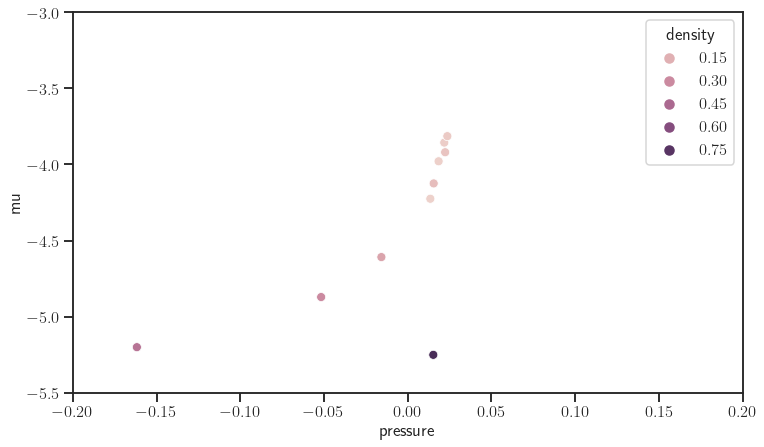

In [78]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(data=df, y="mu", x="pressure", hue="density", ax=ax)
ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-5.5, -3)


<AxesSubplot:xlabel='density', ylabel='pressure'>

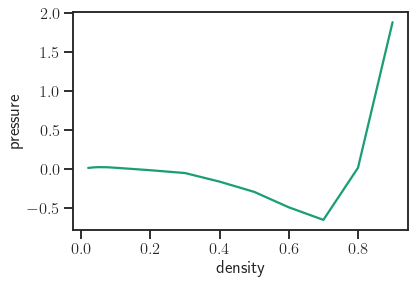

In [73]:
sns.lineplot(data=df, y="pressure", x="density")